# Analyze validation set predictions to determine the best rule for predicting change points
- load detailed validation set predictions
- determine if annotations tend to occur at the start, middle, or end of an utterance
- apply a convolution to each file and plot the results against ground truth change points for 3-5 files
- experiment with different thresholds for the convolution and resulting validation set predictions
- score against reference data with NISTs tool

## Load detailed validation set predictions

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from charm.model.predict import load_reference_data, score_nist, filter_system_preds

/home/tm3229/miniconda3/envs/charm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predictions_dir = '/mnt/swordfish-pool2/ccu/predictions'
model_dir = 'change-point-medium-reweight'
val_preds_filepath = os.path.join(predictions_dir, model_dir, 'val_preds_detailed.csv')

In [3]:
df = pd.read_csv(val_preds_filepath, index_col=0)

/tmp/ipykernel_3758075/1990656355.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(val_preds_filepath, index_col=0)


In [4]:
# exponentiate llr column to get ratio of positive class probability to negative class probability
df['exp_llr'] = df['llr'].apply(lambda x: np.exp(x))
# now recover positive class probability
df['p_pos'] = df['exp_llr'] / (1 + df['exp_llr'])

<Axes: title={'center': 'Distribution of positive class probabilities'}, ylabel='Frequency'>

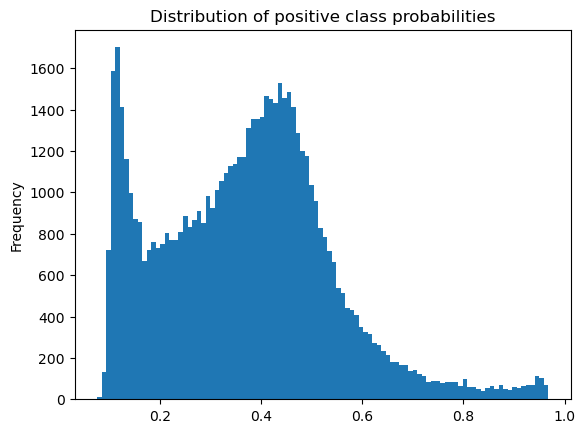

In [5]:
# really interesting that there's a bimodal distribution of positive class probabilities
# seems like the model is very confident that some examples are NOT change points
# and uncertain about most others
df['p_pos'].plot(kind='hist', bins=100, title='Distribution of positive class probabilities')

## Determine if annotations tend to occur at the start, middle, or end of an utterance

In [6]:
# define a midpoint of an utterance
df['midpoint'] = df['start'] + (df['end'] - df['start']) / 2

In [7]:
# get the absolute distance from the start, midpoint, and end to timestamp
df['abs_start_dist'] = df.apply(lambda row: abs(row['start'] - row['timestamp']), axis=1)
df['abs_midpoint_dist'] = df.apply(lambda row: abs(row['midpoint'] - row['timestamp']), axis=1)
df['abs_end_dist'] = df.apply(lambda row: abs(row['end'] - row['timestamp']), axis=1)

In [8]:
# get overall average of the three distances
df[['abs_start_dist', 'abs_midpoint_dist', 'abs_end_dist']].mean()

abs_start_dist       0.790093
abs_midpoint_dist    4.715201
abs_end_dist         9.248731
dtype: float64

In [9]:
# look at average distance by data_type
df.groupby('data_type')[['abs_start_dist', 'abs_midpoint_dist', 'abs_end_dist']].mean()

,abs_start_dist,abs_midpoint_dist,abs_end_dist
data_type,,,
audio,0.975385,0.711538,1.167692
text,0.000000,13.720000,27.440000
video,1.166701,0.672640,1.081117


## Apply a convolution to each file and plot the results against ground truth change points for 3-5 files

In [10]:
# apply the convolutional layer to the positive class probability
def convolve(group_df):
    # define a length 20 1d convolutional layer with "same padding"
    conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10, padding='same', bias=False, dtype=torch.float64)
    # set the weights to all 1s
    conv.weight.data = torch.ones_like(conv.weight.data)
    # requires_grad = False
    conv.weight.requires_grad = False
    
    # convert to a tensor
    tensor = torch.tensor(torch.tensor(group_df['p_pos'].values).view(1, -1))
    with torch.no_grad():
        # apply the convolutional layer
        convolved = conv(tensor)
    # convert back to a numpy array
    return pd.Series(convolved.squeeze().numpy())

In [11]:
df['conv_output'] = df.groupby('file_id', as_index=False, sort=False, group_keys=False).apply(convolve).reset_index(drop=True)

/tmp/ipykernel_3758075/1695683938.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(torch.tensor(group_df['p_pos'].values).view(1, -1))
/home/tm3229/miniconda3/envs/charm/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv1d(input, weight, bias, self.stride,


In [13]:
# load val reference data
val_refs = load_reference_data(split='INTERNAL_VAL')

In [31]:
def get_changepoints(df, text_position='start', audio_video_position='midpoint', use_conv=True):
    # get the change points as follows
    # filter for utterances where the prediction is 1
    # get the midpoint of that utterance (or start or end?) as the timestamp
    if use_conv:
        change_point_df = df[df['conv_pred'] == 1]
    else:
        change_point_df = df[df['prediction'] == 1]
    # if the data_type is text, use the 'start' column as the timestamp
    # if the data_type is audio or video, use the 'midpoint' column as the timestamp
    change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)
    change_point_df = change_point_df[['file_id', 'timestamp', 'data_type', 'llr']].rename(columns={'data_type': 'type'})
    hyps = change_point_df.to_dict(orient='records')
    return hyps

In [29]:
# try a range of thresholds
threshold_results = {}
for i in [1, 2, 3, 4, 5]:
    df['conv_pred'] = (df['conv_output'] > i).astype(int)
    hyps = get_changepoints(df)
    val_results, val_mean_scores = score_nist(val_refs, hyps)
    threshold_results[i] = val_results
    print(i)
    print(val_results)


/tmp/ipykernel_3758075/3882886495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)


1
{'none': {'text': 0.09007763557193041, 'video': 0.020913374743761162, 'audio': 0.010159259112537995, 'harmonic_mean': 0.01906575271269816}, 'highest': {'text': 0.23008437415912342, 'video': 0.048088861073890085, 'audio': 0.02842012940951218, 'harmonic_mean': 0.04972865040332078}, 'lowest': {'text': 0.22000667742333319, 'video': 0.053160882541467044, 'audio': 0.028435087336629777, 'harmonic_mean': 0.05126105674788952}, 'most_similar': {'text': 0.25242903173575537, 'video': 0.048066606332354385, 'audio': 0.033907704050233696, 'harmonic_mean': 0.05529159279219141}}


/tmp/ipykernel_3758075/3882886495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)


2
{'none': {'text': 0.09007763557193041, 'video': 0.020797342584890174, 'audio': 0.009963884668700712, 'harmonic_mean': 0.018803229206359684}, 'highest': {'text': 0.2301179911953847, 'video': 0.04726427278620036, 'audio': 0.027346257742173717, 'harmonic_mean': 0.04833151419823083}, 'lowest': {'text': 0.22001699721521456, 'video': 0.05229199826907737, 'audio': 0.025988160180990014, 'harmonic_mean': 0.04827221741169164}, 'most_similar': {'text': 0.25117501449463886, 'video': 0.04731285301820302, 'audio': 0.0332158553347969, 'harmonic_mean': 0.05432489786317884}}


/tmp/ipykernel_3758075/3882886495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)


3
{'none': {'text': 0.09011032323984103, 'video': 0.020320328786437206, 'audio': 0.008676903067597962, 'harmonic_mean': 0.01708838887899262}, 'highest': {'text': 0.23110547292336892, 'video': 0.04494220178592209, 'audio': 0.02263299652620575, 'harmonic_mean': 0.042396169972770195}, 'lowest': {'text': 0.22028772764240528, 'video': 0.049823925450465226, 'audio': 0.02197973765458269, 'harmonic_mean': 0.042791949544331916}, 'most_similar': {'text': 0.2502949634270376, 'video': 0.045426327205515225, 'audio': 0.027084058223382113, 'harmonic_mean': 0.04767122796983058}}


/tmp/ipykernel_3758075/3882886495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)


4
{'none': {'text': 0.08941599263276626, 'video': 0.019124987622538857, 'audio': 0.007501662514219756, 'harmonic_mean': 0.015245832856710093}, 'highest': {'text': 0.22709809513574902, 'video': 0.03943450226031392, 'audio': 0.017717391760009454, 'harmonic_mean': 0.03480132909070033}, 'lowest': {'text': 0.21324344755945301, 'video': 0.0451508002233247, 'audio': 0.01845420382522856, 'harmonic_mean': 0.03702530193344028}, 'most_similar': {'text': 0.2513057205060078, 'video': 0.037711104647338095, 'audio': 0.02094902213604477, 'harmonic_mean': 0.038347709598715925}}


/tmp/ipykernel_3758075/3882886495.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)


5
{'none': {'text': 0.08745336973363207, 'video': 0.00894668593982218, 'audio': 0.004319548763993208, 'harmonic_mean': 0.008457528385934306}, 'highest': {'text': 0.21433578290096666, 'video': 0.022368461420876538, 'audio': 0.006629946960424316, 'harmonic_mean': 0.014984854250264672}, 'lowest': {'text': 0.20416124853888246, 'video': 0.022801220209915467, 'audio': 0.008623819898329702, 'harmonic_mean': 0.018213467019919327}, 'most_similar': {'text': 0.24615310270394833, 'video': 0.02222956076635832, 'audio': 0.007687991021324354, 'harmonic_mean': 0.016748487744503535}}


In [32]:
hyps = get_changepoints(df, use_conv=False)
val_results, val_mean_scores = score_nist(val_refs, hyps)
print(val_results)

/tmp/ipykernel_3758075/1848209145.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  change_point_df['timestamp'] = change_point_df.apply(lambda row: row[text_position] if row['data_type'] == 'text' else row[audio_video_position], axis=1)


{'none': {'text': 0.08751618845863819, 'video': 0.01667724836866855, 'audio': 0.006087187666135035, 'harmonic_mean': 0.012729779768339767}, 'highest': {'text': 0.2202332946811629, 'video': 0.027045535618300514, 'audio': 0.011400079324607626, 'harmonic_mean': 0.023213704210382477}, 'lowest': {'text': 0.21149828863431197, 'video': 0.03502501702405858, 'audio': 0.01302426433639771, 'harmonic_mean': 0.027258116873715817}, 'most_similar': {'text': 0.24156155179030922, 'video': 0.026568444313805232, 'audio': 0.009337727558066541, 'harmonic_mean': 0.020151701410996526}}


In [33]:
df['conv_pred'] = 1
hyps = get_changepoints(df, use_conv=True)
val_results, val_mean_scores = score_nist(val_refs, hyps)
print(val_results)

{'none': {'text': 0.09007763557193041, 'video': 0.02091330385847976, 'audio': 0.010159141267073624, 'harmonic_mean': 0.019065594725642666}, 'highest': {'text': 0.23008437415912342, 'video': 0.04808722745442487, 'audio': 0.02842012940951218, 'harmonic_mean': 0.04972806808067999}, 'lowest': {'text': 0.22000667742333319, 'video': 0.05328252017860827, 'audio': 0.028429865164540408, 'harmonic_mean': 0.05129303211409531}, 'most_similar': {'text': 0.25242903173575537, 'video': 0.048032258491508564, 'audio': 0.03390358964931619, 'harmonic_mean': 0.055272791265187506}}


M010052PC


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


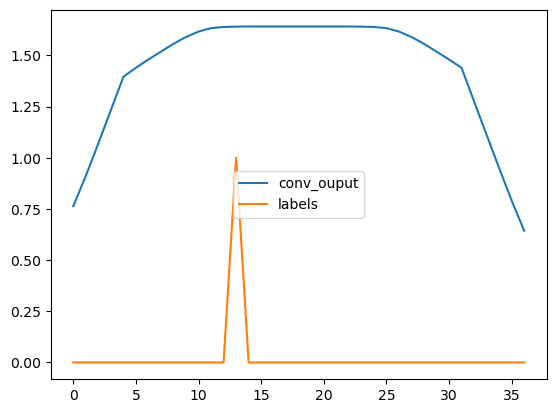

M01000HKE


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


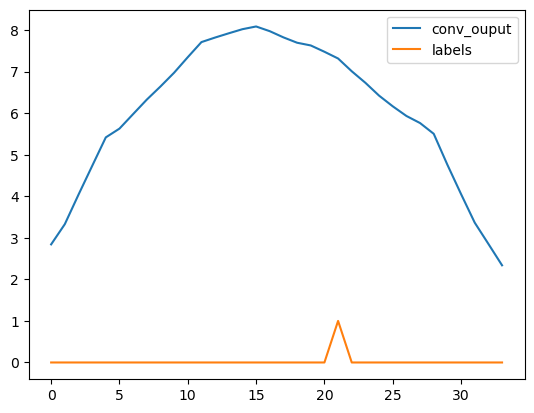

M010008AQ


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


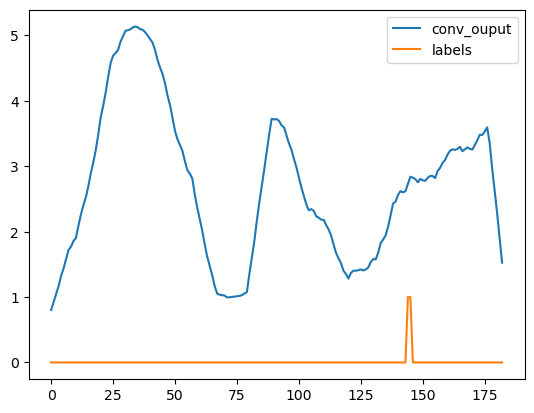

M01004V0H


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


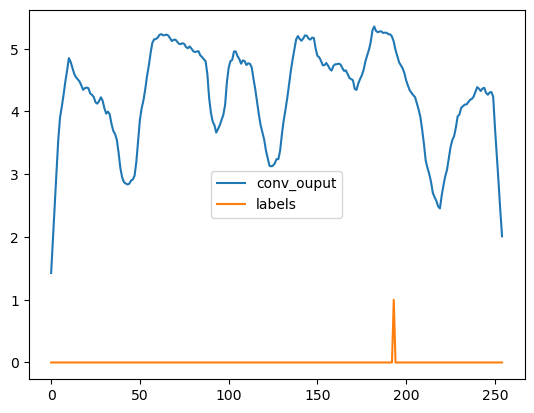

M01003M51


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


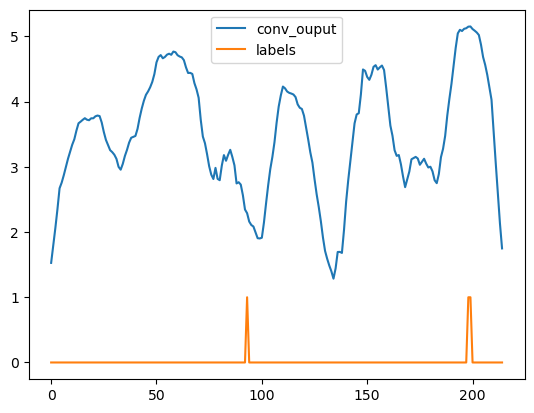

M01003O73


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


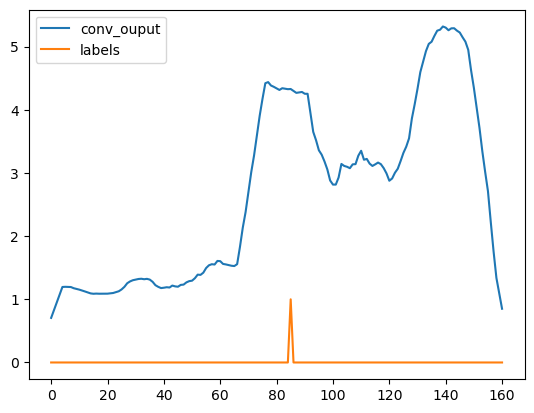

M01001X4V


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


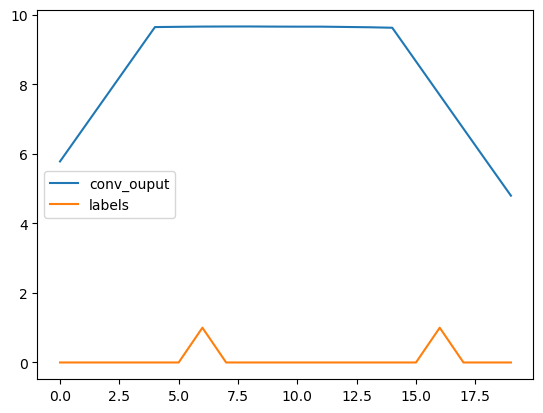

M01004F15


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


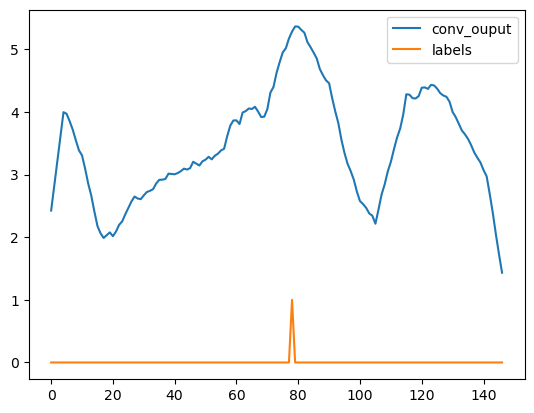

M01000H5M


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


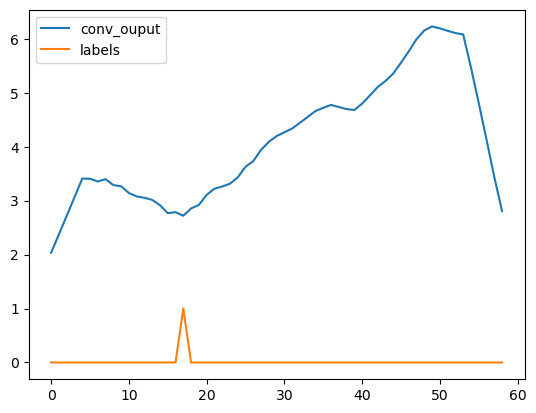

M01003OJJ


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


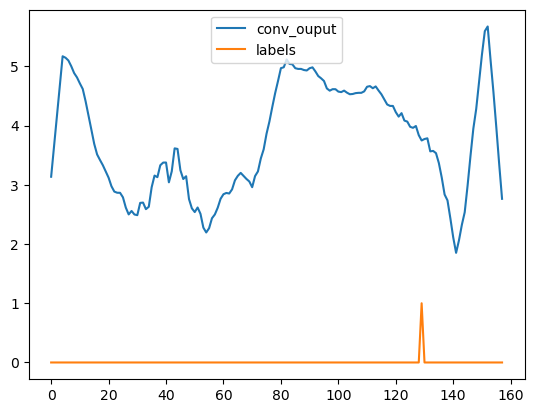

M01003YD4


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


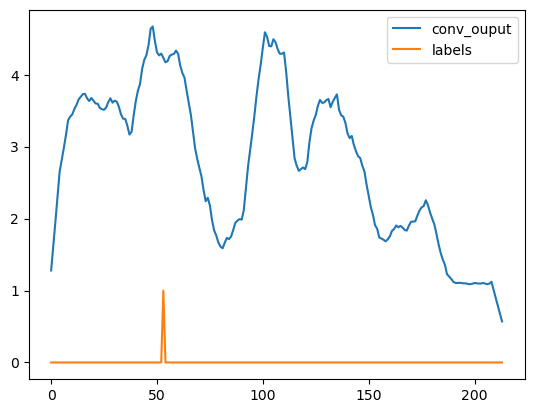

M01003Y28


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


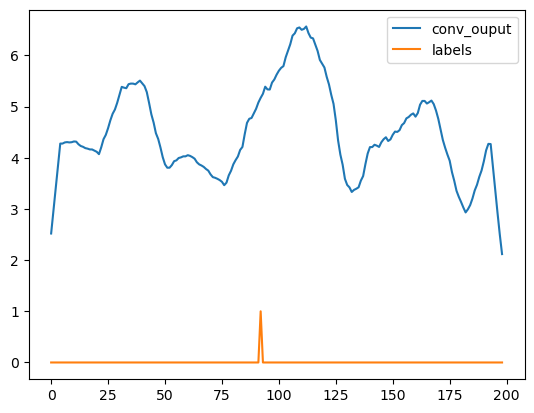

M01001UM2


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


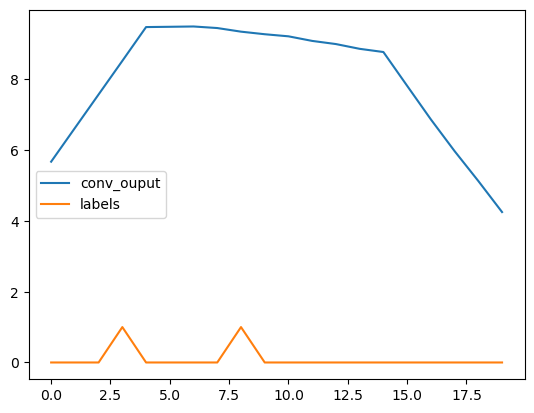

M0100473F


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


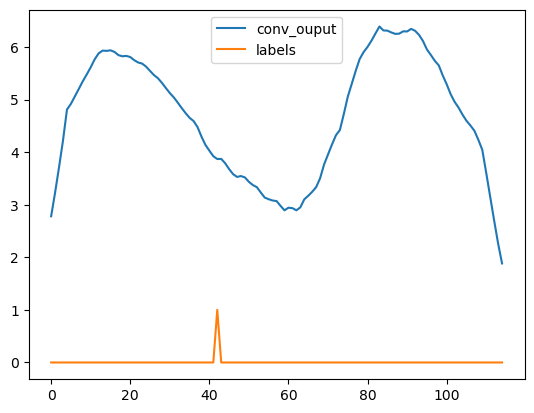

M010045W8


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


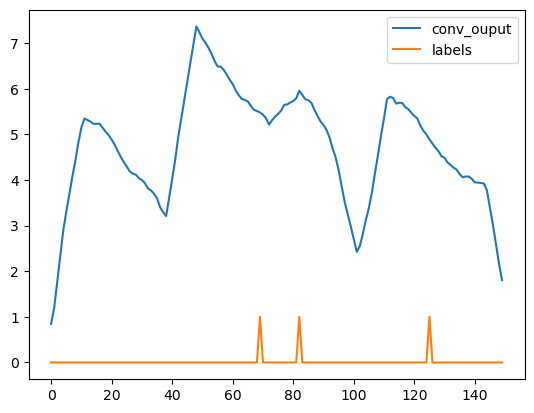

M01000HAS


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


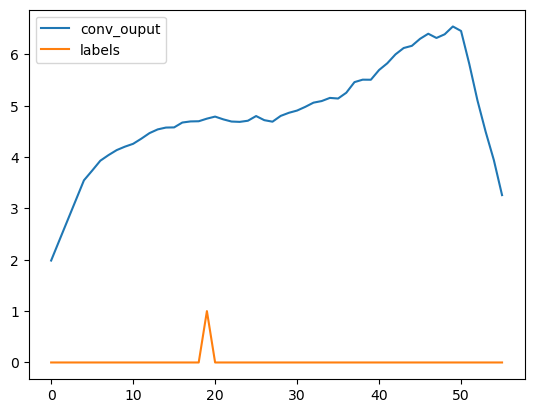

M01000C0M


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


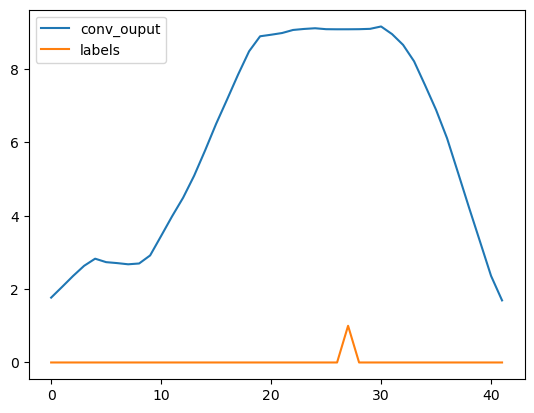

M01004QPS


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


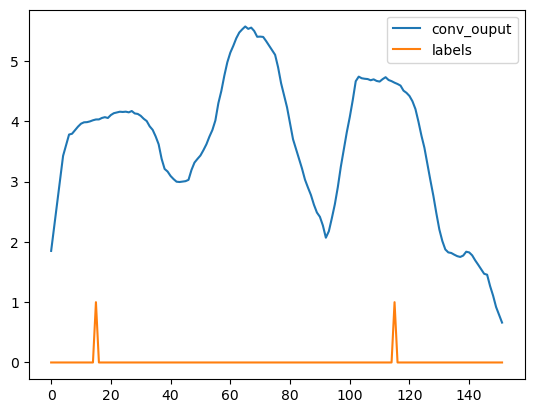

M01001LIA


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


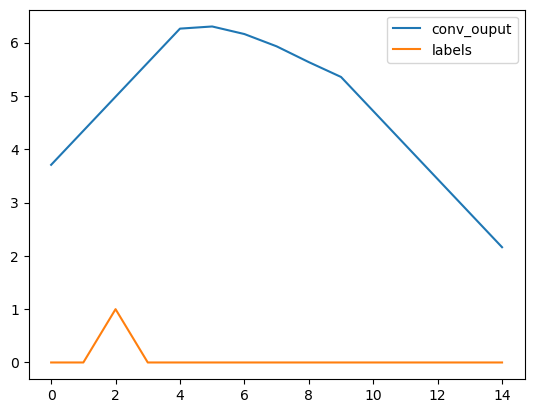

M01001ZTJ


/tmp/ipykernel_3739095/1691605534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_df['conv_ouput'] = conv(torch.tensor(file_df['p_pos'].values).view(1, -1)).squeeze().numpy()


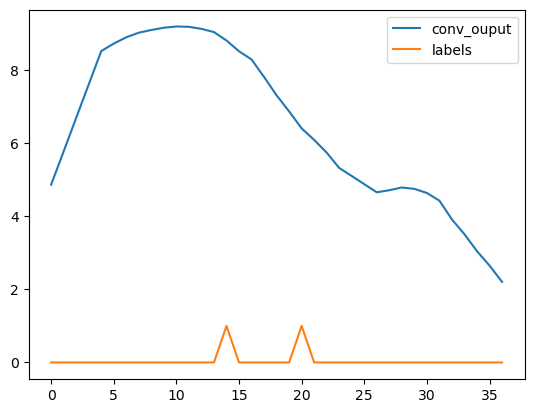

In [102]:
for file_id in file_ids:
    print(file_id)
    file_df = df[df['file_id'] == file_id]
    # file_df['timestamp'].value_counts()
    file_df.reset_index(inplace=True)
    file_df[['conv_ouput', 'labels']].plot()
    plt.show()

In [103]:
# examine M01003M51
file_id = 'M01003M51'
file_df = df[df['file_id'] == file_id]

In [104]:
file_df

,index,file_id,split,anno_start,anno_end,url,status_in_corpora,data_type,release,processed,...,social_orientation_preds,social_orientation,prediction,llr,exp_llr,p_pos,midpoint,abs_start_dist,abs_midpoint_dist,abs_end_dist
14357,14357,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Assured-Dominant,NaN,0,-1.083311,0.338473,0.252880,69.5,NaN,NaN,NaN
14358,14358,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Aloof-Introverted,NaN,0,-1.002828,0.366840,0.268386,70.5,NaN,NaN,NaN
14359,14359,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Aloof-Introverted,NaN,0,-1.038813,0.353875,0.261379,71.5,NaN,NaN,NaN
14360,14360,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Warm-Agreeable,NaN,0,-1.106251,0.330797,0.248570,72.5,NaN,NaN,NaN
14361,14361,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Warm-Agreeable,NaN,0,-1.140436,0.319680,0.242240,73.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14567,14567,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Aloof-Introverted,NaN,0,-0.685312,0.503933,0.335077,364.0,NaN,NaN,NaN
14568,14568,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Unassuming-Ingenuous,NaN,0,-0.435180,0.647148,0.392890,365.5,NaN,NaN,NaN
14569,14569,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Aloof-Introverted,NaN,0,-0.572791,0.563949,0.360593,366.5,NaN,NaN,NaN
14570,14570,M01003M51,val,69.1,369.1,na,[('LDC2022E22_CCU_TA1_Mandarin_Chinese_Mini_Ev...,video,LDC2023E01,True,...,Gregarious-Extraverted,NaN,0,-0.647419,0.523395,0.343571,368.0,NaN,NaN,NaN
